In [1]:
from IPython.display import Image

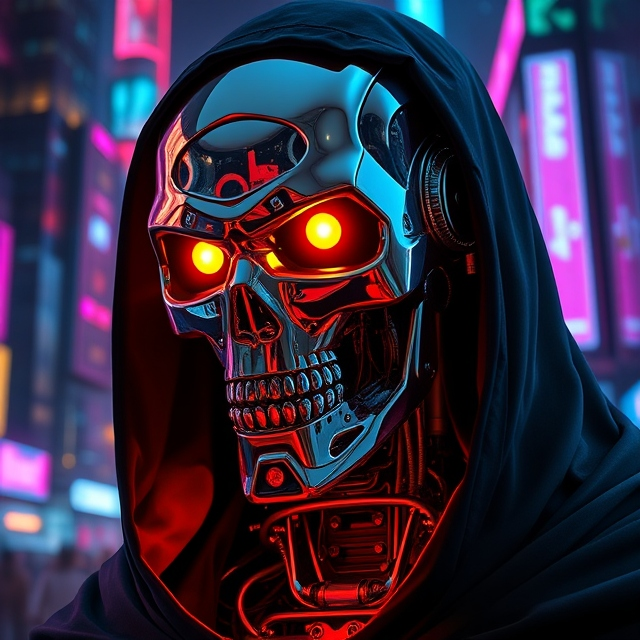

In [2]:
Image(filename = 'MNIST-MLP.jpeg')

# MNIST Classification w/ Fully Connected Neural Network (MLP)

#### Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Introduction

Welcome to this tutorial project on **MNIST Classification** using a **Fully Connected Neural Network (MLP)** implemented in **PyTorch**. In this project, we'll walk through the process of building, training, and evaluating a simple neural network to recognize handwritten digits from the MNIST dataset.

## Objectives

- **Build an MLP in PyTorch:** Construct a simple neural network architecture for classification tasks.
- **Train the Model:** Implement the training loop to optimize the model's performance.
- **Evaluate the Model:** Assess the trained model's accuracy on unseen data.
- **Perform Inference:** Use the trained model to make predictions on new images.

Let's get started!

## Prerequisites

Before diving into the code, ensure you have the following installed:

- **Python 3.7+**
- **PyTorch**
- **Torchvision**
- **Pillow**
- **IPython (for Jupyter Notebook display capabilities)**

You can install the necessary libraries using `!pip`:

In [3]:
!pip install torch torchvision Pillow

## Importing Libraries

First, we'll import the essential libraries required for our project.

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image as PILImage
from IPython.display import display, Image as IPImage

## Defining the Neural Network Model

We'll define a simple Fully Connected Neural Network (MLP) with two hidden layers. This model will take in flattened 28x28 grayscale images and output logits for 10 digit classes (0-9).

In [5]:
class MNISTModel(nn.Module):
    """
    A Fully Connected Neural Network (MLP) for classifying MNIST handwritten digits.
    This model consists of two hidden layers with ReLU activation and dropout for regularization.
    It processes flattened 28x28 grayscale images and outputs logits for 10 digit classes.
    """

    def __init__(self):
        """
        Initialize the MNISTModel.
    
        Sets up the layers of the MLP including input, hidden, dropout, and output layers.
        """
        # initialize the base class (nn.Module) to inherit its methods and properties
        super(MNISTModel, self).__init__()
    
        # flatten layer to convert 2D image into 1D tensor
        self.flatten = nn.Flatten()
    
        # first fully connected layer: 28*28 or 784 input features, 128 output features
        self.fc1 = nn.Linear(28 * 28, 128)
        # ReLU activation for the first hidden layer
        self.relu1 = nn.ReLU()
        # dropout layer with 20% probability to prevent overfitting
        #self.dropout1 = nn.Dropout(0.2)
    
        # second fully connected layer: 128 input features, 64 output features
        self.fc2 = nn.Linear(128, 64)
        # ReLU activation for the second hidden layer
        self.relu2 = nn.ReLU()
        # dropout layer with 20% probability to prevent overfitting
        #self.dropout2 = nn.Dropout(0.2)
    
        # output layer: 64 input features, 10 output features (number of classes)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        """
        Define the forward pass of the MLP.
    
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28).
    
        Returns:
            torch.Tensor: Output logits of shape (batch_size, 10).
        """
        # x.shape: torch.Size([64, 1, 28, 28])
        
        # flatten the input image
        x = self.flatten(x)

        # x.shape: torch.Size([64, 784])
    
        # pass through first fully connected layer
        x = self.fc1(x)
        x = self.relu1(x)
        # x = self.dropout1(x)
    
        # pass through second fully connected layer
        x = self.fc2(x)
        x = self.relu2(x)
        # x = self.dropout2(x)
    
        # pass through output layer
        x = self.fc3(x)

        # return the output logits of shape (batch_size, 10), representing class scores
        return x

## Loading the Data

We'll use the MNIST dataset, which consists of 70,000 grayscale images of handwritten digits (60,000 for training and 10,000 for testing). Each image is 28x28 pixels.

### Data Transformations

For simplicity, we'll only convert the images to PyTorch tensors without applying normalization. This makes the data preprocessing steps easier to understand for beginners.

### Define Transformation: Only Convert Images to Tensors

In [6]:
transform = transforms.ToTensor()

### Downloading and Loading the Datasets

We'll download the MNIST dataset and create DataLoaders for batching the data during training and testing.

### Load the Training and Test Datasets

In [7]:
train_dataset = datasets.MNIST(root='./data', train=True,
download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False,
download=True, transform=transform)

### Create DataLoaders for Training and Testing

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64,
shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64,
shuffle=True)

## Initializing the Model, Loss Function, and Optimizer

We'll set up our model, define the loss function, and choose an optimizer for training.

### Device Configuration: Use MPS if Available on macOS, else CUDA or CPU

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device for computation.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for computation.")
else:
    device = torch.device("cpu")
    print("Using CPU for computation.")

Using Apple MPS device for computation.


### Initialize the Model


In [10]:
model = MNISTModel().to(device)

### Define Loss Function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()                   # suitable for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

## Training the Model

We'll define a function to train the model for one epoch. This function processes the training data, computes the loss, and updates the model's weights.

In [12]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        device (torch.device): The device to perform computations on.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function.
        epoch (int): Current epoch number.
    """
    
    # set the model to training mode
    model.train()

    # set the model to training mode
    running_loss = 0.0

    # initialize the count of correctly predicted samples
    correct = 0

    # initialize the count of correctly predicted samples
    total = 0

    # iterate over batches of data and labels
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # move data and target tensors to the configured device
        data, target = data.to(device), target.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward pass
        outputs = model(data)
    
        # compute loss
        loss = criterion(outputs, target)
    
        # backward pass and optimization
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
    
        # compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # print every 100 batches
        if batch_idx % 100 == 99:  
            print(f'Epoch [{epoch}], Batch [{batch_idx + 1}], '
                  f'Loss: {running_loss / 100:.4f}, '
                  f'Accuracy: {100 * correct / total:.2f}%')
            running_loss = 0.0

## Evaluating the Model

After training, we'll evaluate the model's performance on the test dataset to assess its accuracy.

In [13]:
def test(model, device, test_loader, criterion):
    """
    Evaluate the model on the test dataset.

    Args:
    model (nn.Module): The trained neural network model.
    device (torch.device): The device to perform computations on.
    test_loader (DataLoader): DataLoader for test data.
    criterion (nn.Module): Loss function.

    Returns:
        tuple: (average_loss, accuracy) on the test dataset.
    """

    # set the model to evaluation mode
    model.eval()
    
    # initialize the cumulative loss for the test dataset
    test_loss = 0.0

    # initialize the count of correctly predicted samples
    correct = 0

    # initialize the total number of samples processed
    total = 0
    
    # disable gradient computation for evaluation; prevent PyTorch from computing gradients to save memory and speed up evaluation
    with torch.no_grad():

        # iterate over batches of test data and labels
        for data, target in test_loader:

            # move data and labels to the configured device
            data, target = data.to(device), target.to(device)
    
            # forward pass; generate predictions from the model
            outputs = model(data)
    
            # compute loss; calculate the loss for the current batch
            loss = criterion(outputs, target)

            # accumulate the loss over all batches
            test_loss += loss.item()
    
            # compute accuracy; get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # increment the total number of samples processed
            total += target.size(0)

            # count the number of correct predictions
            correct += (predicted == target).sum().item()

    # calculate the average loss over all batches
    average_loss = test_loss / len(test_loader)

    # calculate the accuracy as a percentage
    accuracy = 100 * correct / total

    # print the average loss; print the accuracy in percentage format
    print(f'\nTest set: Average loss: {average_loss:.4f}, '
          f'Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')

    # return the average loss and accuracy
    return average_loss, accuracy

## Training and Testing the Model

We'll now train the model for a specified number of epochs and evaluate its performance after each epoch.

In [14]:
def main():
    """
    Main function to execute the training and testing of the MNIST model.

    Sets up data loaders, initializes the model, defines the loss function and optimizer,
    runs the training and evaluation loops, and demonstrates inference on a sample image.
    """
    # define the number of training epochs
    num_epochs = 10  

    # iterate over epochs and perform training and testing
    for epoch in range(1, num_epochs + 1):
        
        # train the model
        train(model, device, train_loader, optimizer, criterion, epoch)  

        # test the model
        test(model, device, test_loader, criterion) 

    # define the path to save the trained model
    model_path = "mnist_mlp_model.pth"

    # save the model's state dictionary to the specified file
    torch.save(model.state_dict(), model_path)

    # print confirmation that the model has been saved
    print(f'Model saved to {model_path}')

    # specify the path to the sample image for inference
    sample_image_path = 'sample_digit.png'

    # check if the sample image exists to perform inference
    if os.path.exists(sample_image_path):
        
        # initialize the InferenceModel with the saved model and device
        inference_model = InferenceModel(model_path, device)

        # predict the class and confidence score for the sample image
        predicted_class, confidence = inference_model.predict(sample_image_path)

        # display the sample image
        display(IPImage(filename='sample_digit.png'))

        # print the predicted class and confidence score
        print(f'Predicted Class: {predicted_class}, Confidence: {confidence * 100:.2f}%')

    # handle the case if image not found
    else:
        
        # print a message if the sample image is not found
        print(f'No sample image found at {sample_image_path}. Skipping inference demonstration.')

## Performing Inference

We'll create an `InferenceModel` class to load the trained model and make predictions on new images.

In [15]:
class InferenceModel:
    """
    A class for performing inference using a trained MNISTModel.

    This class loads a saved model and provides a method to predict the class of a given image.
    """

    def __init__(self, model_path, device):
        """
        Initialize the InferenceModel.

        Args:
            model_path (str): Path to the saved model file.
            device (torch.device): The device to perform computations on.
        """
        # store the device for inference
        self.device = device

        # load the MNISTModel and move it to the specified device
        self.model = MNISTModel().to(self.device)

        # load the model's saved state dictionary
        self.model.load_state_dict(torch.load(model_path, map_location=self.device, weights_only=True))

        # set the model to evaluation mode
        self.model.eval()

        # print confirmation that the model has been loaded
        print(f'Model loaded from {model_path}')

        # define the image transformations used during training
        self.transform = transforms.Compose([

            # convert image to grayscale
            transforms.Grayscale(),  

            # resize the image to 28x28 pixels
            transforms.Resize((28, 28)),  

            # convert the image to a tensor
            transforms.ToTensor(),  

            # normalize using MNIST mean and std
            transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean and std
        ])

    def predict(self, image):
        """
        Predict the class of a given image.

        Args:
            image (PIL.Image.Image or str): A PIL Image or a path to an image file.

        Returns:
            tuple: (predicted_class, confidence_score)
        """
        
        # check if the input is a file path
        if isinstance(image, str):
            
            # raise an error if the file does not exist
            if not os.path.exists(image):
                raise FileNotFoundError(f'Image file {image} does not exist.')

            # open the image file and convert it to grayscale
            image = PILImage.open(image).convert('L')

        # Check if the input is a valid PIL Image object
        elif not isinstance(image, PILImage.Image):
            
            # raise an error if the input is not a valid image
            raise TypeError('Input must be a PIL Image or a valid image file path.')

        # apply the transformations to the image
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)  # Add batch dimension

        # disable gradient computation during inference
        with torch.no_grad():
            
            # perform a forward pass through the model
            output = self.model(input_tensor)

            # apply the softmax function to get class probabilities
            probabilities = nn.functional.softmax(output, dim=1)

            # get the predicted class and its confidence score
            confidence, predicted = torch.max(probabilities, 1)

        # return the predicted class and confidence score
        return predicted.item(), confidence.item()

In [16]:
main()

Epoch [1], Batch [100], Loss: 2.2913, Accuracy: 12.81%
Epoch [1], Batch [200], Loss: 2.2526, Accuracy: 20.82%
Epoch [1], Batch [300], Loss: 2.1932, Accuracy: 25.76%
Epoch [1], Batch [400], Loss: 2.1001, Accuracy: 30.49%
Epoch [1], Batch [500], Loss: 1.9321, Accuracy: 35.02%
Epoch [1], Batch [600], Loss: 1.6886, Accuracy: 39.14%
Epoch [1], Batch [700], Loss: 1.3963, Accuracy: 43.09%
Epoch [1], Batch [800], Loss: 1.1407, Accuracy: 46.83%
Epoch [1], Batch [900], Loss: 0.9415, Accuracy: 50.27%

Test set: Average loss: 0.8136, Accuracy: 8103/10000 (81.03%)

Epoch [2], Batch [100], Loss: 0.7987, Accuracy: 80.64%
Epoch [2], Batch [200], Loss: 0.7069, Accuracy: 81.22%
Epoch [2], Batch [300], Loss: 0.6327, Accuracy: 81.82%
Epoch [2], Batch [400], Loss: 0.5943, Accuracy: 82.36%
Epoch [2], Batch [500], Loss: 0.5699, Accuracy: 82.79%
Epoch [2], Batch [600], Loss: 0.5462, Accuracy: 83.14%
Epoch [2], Batch [700], Loss: 0.4860, Accuracy: 83.65%
Epoch [2], Batch [800], Loss: 0.4880, Accuracy: 84.04%
E

Predicted Class: 9, Confidence: 100.00%
